# SEGUROS AUTOMOVILÍSTICOS

El objetivo de este trabajo es crear un modelo que sea útil a la hora de tomar decisiones en una aseguradora de vehículos.

Los datos se han obtenido de la siguiente fuente: //www.kaggle.com/datasets/tbsteal/canadian-car-accidents-19942014?select=drivingLegend.pdf csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import sklearn
random_state = 100
warnings.filterwarnings('ignore')

# 0. Lectura y limpieza de datos


In [3]:
df = pd.read_csv('NCDB_1999_to_2014.csv')

In [4]:
df.head(10)

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3
5,1999,1,1,17,2,03,QQ,QQ,1,2,...,01,01,1984,01,M,28,11,1,UU,1
6,1999,1,1,17,2,03,QQ,QQ,1,2,...,02,01,1991,01,M,21,11,1,UU,1
7,1999,1,1,17,2,03,QQ,QQ,1,2,...,02,01,1991,02,F,UU,13,2,UU,2
8,1999,1,1,17,2,03,QQ,QQ,1,2,...,03,01,1992,01,M,UU,11,2,UU,1
9,1999,1,1,15,2,01,04,UU,1,5,...,01,01,1997,01,M,61,11,1,UU,1


Para facilitar la limpieza el data set se ha subdividido en tres data sets por cada categoría principal de datos: colisión, vehículo y conductor.

En primer lugar, hemos creado nuevos grupos en los que se han incluido otras categorías como la de 'otros' (QQ o Q) o 'no clasificables'(NN).

El resto de observaciones son desconocidas (UU o U) o no provisionadas por la jurisdicción (XX o X) y se tratarán como datos missing. 

In [5]:
#Datos colisión
colision=df[['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_SEV','C_VEHS','C_CONF',
            'C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF']]


#Otros 
c0=colision[['C_CONF']].replace('QQ',42,regex=True) #Otros=categoría 42
c1=colision[['C_RCFG']].replace('QQ',13,regex=True) #Otros=categoría 13
c2=colision[['C_TRAF']].replace('QQ',19,regex=True) #Otros=categoría 19
c3=colision[['C_WTHR']].replace('Q',8,regex=True) #Otros=categoría 8
c4=colision[['C_RSUR']].replace('Q',10,regex=True)#Otros=categoría 10
c5=colision[['C_RALN']].replace('Q',7,regex=True) #Otros=categoría 7

colision['C_CONF']=c0
colision['C_RCFG']=c1
colision['C_TRAF']=c2
colision['C_WTHR']=c3
colision['C_RSUR']=c4
colision['C_RALN']=c5


#Datos missing
colision=colision.replace('[^0-9]+',np.nan,regex=True)

In [6]:
colision.head(10)

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF
0,1999,1,1,20,2,02,34,NaN,1,5,3,03
1,1999,1,1,20,2,02,34,NaN,1,5,3,03
2,1999,1,1,20,2,02,34,NaN,1,5,3,03
3,1999,1,1,08,2,01,01,NaN,5,3,6,18
4,1999,1,1,08,2,01,01,NaN,5,3,6,18
5,1999,1,1,17,2,03,42,13,1,2,1,01
6,1999,1,1,17,2,03,42,13,1,2,1,01
7,1999,1,1,17,2,03,42,13,1,2,1,01
8,1999,1,1,17,2,03,42,13,1,2,1,01
9,1999,1,1,15,2,01,04,NaN,1,5,NaN,NaN


In [7]:
#Datos vehículo
vehiculo=df[['V_ID','V_TYPE','V_YEAR']]


#Otros 
v0=vehiculo[['V_TYPE']].replace('NN',24,regex=True) 
v1=v0.replace('QQ',25,regex=True) #No clasificable=categoría 42
v2=vehiculo[['V_YEAR']].replace('NNNN',1,regex=True) #No clasificable=1

vehiculo['V_TYPE']=v1


#Datos missing
vehiculo=vehiculo.replace('[^0-9]+',np.nan,regex=True)


In [9]:
#Datos afectados
#En este caso,no incluiremos en un principio la columna 'P_SEX' porque no es numérica y no queremos que se trate como NAs. 
#Posteriormente la añadiremos de nuevo

persona=df[['P_ID','P_AGE','P_PSN','P_ISEV',
             'P_SAFE','P_USER']]


#Otros 
C0=persona[['P_ID']].replace('NN',100,regex=True) #No clasificable=categoría 100
C1=persona[['P_AGE']].replace('NN',100,regex=True) #No clasificable=categoría 100
C2=persona[['P_PSN']].replace('NN',8,regex=True) #No clasificable=categoría 100
C3=C2.replace('QQ',101,regex=True)#Otros=categoría 101
C4=persona[['P_ISEV']].replace('N',4,regex=True) #No clasificable=categoría 4
C5=persona[['P_SAFE']].replace('NN',14,regex=True) #No clasificable=categoría 14
C6=C5.replace('QQ',15,regex=True)#Otros=categoría 15


persona['P_ID']=C0
persona['P_AGE']=C1
persona['P_PSN']=C3
persona['P_ISEV']=C4
persona['P_SAFE']=C6


#Datos missing
persona=persona.replace('[^0-9]+',np.nan,regex=True)
persona['P_SEX']=df['P_SEX']


In [12]:
dataframe0=pd.concat([colision, vehiculo], axis=1,)
dataframe=pd.concat([dataframe0,persona], axis=1,)

In [10]:
def missing_summary(dataframe):
    num_elementos = dataframe.count()
    num_missing = dataframe.isna().sum()
    missing_summary = pd.DataFrame(index=num_elementos.index, 
                               data={'total':num_elementos, 
                                     'missing':num_missing,
                                     'missing_rate (%)': round(num_missing/num_elementos * 100, 2)})
    return missing_summary

In [13]:
missing_summary(dataframe)

,total,missing,missing_rate (%)
C_YEAR,5860405,0,0.00
C_MNTH,5860020,385,0.01
C_WDAY,5859082,1323,0.02
C_HOUR,5800996,59409,1.02
C_SEV,5860405,0,0.00
C_VEHS,5859861,544,0.01
C_CONF,5681386,179019,3.15
C_RCFG,5355757,504648,9.42
C_WTHR,5772430,87975,1.52
C_RSUR,5781954,78451,1.36


Podemos ver que hay algunas variables que tienen un mayor número de datos missing, como la configuración de la carretera (C_RCFG) o el año del modelo del vehículo (V_YEAR). 
Aun así, el dataset contiene mucha información y el porcentaje de NAs es muy pequeño y la pérdida de información es apenas relevante. Por ello, hemos decidido eliminar este tipo de datos.

In [23]:
df=dataframe.dropna()
df

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,P_SEX
44,1999,1,1,12,2,01,04,13,1,5,...,01,01,1993,01,25,11,2,02,1,F
45,1999,1,1,10,2,01,03,13,1,2,...,01,01,1998,01,65,11,2,02,1,M
46,1999,1,1,15,2,01,42,01,1,1,...,01,01,1995,01,17,11,1,02,1,M
48,1999,1,1,23,2,01,02,13,1,5,...,01,01,1997,01,25,11,2,02,1,M
52,1999,1,1,09,2,02,34,02,1,1,...,01,01,1992,01,33,11,2,02,1,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860376,2014,12,7,14,2,02,41,01,1,5,...,2,05,2008,01,44,11,1,02,1,M
5860377,2014,12,7,14,2,02,41,01,1,5,...,2,05,2008,02,34,13,2,02,2,M
5860378,2014,12,7,19,2,01,03,01,1,3,...,1,01,2001,01,35,11,2,02,1,F
5860379,2014,12,7,19,2,01,03,01,1,3,...,1,01,2001,02,26,13,1,02,2,M


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3896509 entries, 44 to 5860380
Data columns (total 22 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   C_YEAR  int64 
 1   C_MNTH  object
 2   C_WDAY  object
 3   C_HOUR  object
 4   C_SEV   int64 
 5   C_VEHS  object
 6   C_CONF  object
 7   C_RCFG  object
 8   C_WTHR  object
 9   C_RSUR  object
 10  C_RALN  object
 11  C_TRAF  object
 12  V_ID    object
 13  V_TYPE  object
 14  V_YEAR  int32 
 15  P_ID    object
 16  P_AGE   object
 17  P_PSN   object
 18  P_ISEV  object
 19  P_SAFE  object
 20  P_USER  object
 21  P_SEX   object
dtypes: int32(1), int64(2), object(19)
memory usage: 797.9+ MB


## 1. Análisis descriptivo 

En primer lugar, observamos qué porcentaje de tipos de vehículo y de conductores aparecen más repetidos en el data set, y éstos serán los más probables a provocar un accidente.

In [24]:
collision_data = [col for col in df.columns if col.startswith('C')]
vehicle_data = [col for col in df.columns if col.startswith('V')]
personal_data = [col for col in df.columns if col.startswith('P')]

In [25]:
columns_to_count = vehicle_data + personal_data

In [26]:
for index,col in enumerate(columns_to_count):
    columns_to_count[index]=(df[col].value_counts().nlargest())/len(df)*100

In [27]:
vehicle_data_frames = {}
for col in vehicle_data:
    new_df = pd.DataFrame((df[col].value_counts())/len(df)*100)
    vehicle_data_frames[col] = new_df
personal_data_frames = {}
for col in personal_data:
    new_df = pd.DataFrame((df[col].loc[df["P_PSN"] == "11"].value_counts())/len(df.loc[df["P_PSN"] == "11"])*100)
    personal_data_frames[col] = new_df

In [30]:
vehicle_data_frames

{'V_ID':          V_ID
 01  35.578463
 02  24.043650
 1   19.997362
 2   13.488356
 03   3.479705
 ..        ...
 55   0.000026
 56   0.000026
 48   0.000026
 57   0.000026
 99   0.000026
 
 [138 rows x 1 columns],
 'V_TYPE':        V_TYPE
 01  89.476426
 06   2.892846
 14   2.315124
 07   1.385753
 08   1.257639
 05   1.174308
 11   0.911560
 09   0.374463
 17   0.087694
 23   0.046144
 18   0.043834
 10   0.018170
 21   0.016040,
 'V_YEAR':         V_YEAR
 2000  6.293942
 2002  5.713627
 1998  5.613153
 1999  5.558180
 2001  5.458091
 ...        ...
 1913  0.000077
 1907  0.000051
 1909  0.000026
 1906  0.000026
 1904  0.000026
 
 [111 rows x 1 columns]}

In [31]:
personal_data_frames

{'P_ID':          P_ID
 01  99.469738
 02   0.364670
 03   0.099466
 04   0.036778
 05   0.014637
 06   0.006025
 07   0.002735
 08   0.001109
 09   0.000702
 10   0.000517
 11   0.000333
 12   0.000333
 14   0.000259
 16   0.000259
 13   0.000259
 15   0.000185
 17   0.000148
 19   0.000111
 21   0.000111
 41   0.000111
 24   0.000111
 28   0.000074
 32   0.000074
 25   0.000074
 23   0.000074
 45   0.000074
 22   0.000074
 26   0.000074
 33   0.000074
 30   0.000074
 43   0.000074
 27   0.000074
 20   0.000074
 34   0.000074
 36   0.000037
 50   0.000037
 42   0.000037
 39   0.000037
 29   0.000037
 31   0.000037
 38   0.000037
 52   0.000037
 40   0.000037
 47   0.000037
 18   0.000037
 49   0.000037,
 'P_AGE':        P_AGE
 19  2.823553
 18  2.808915
 20  2.728596
 21  2.623475
 22  2.504494
 ..       ...
 02  0.000665
 04  0.000628
 06  0.000591
 97  0.000554
 03  0.000407
 
 [100 rows x 1 columns],
 'P_PSN':     P_PSN
 11  100.0,
 'P_ISEV':       P_ISEV
 2  52.849482
 1  40.68865

A continuación, graficamos para un análisis más claro de los datos.

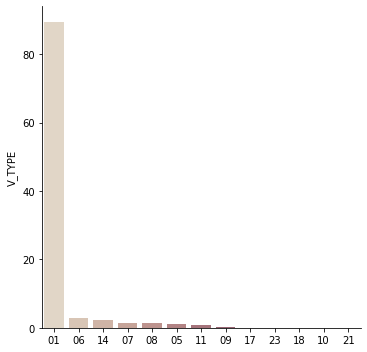

In [32]:
#Tipo de vehículo
sns.catplot(x= vehicle_data_frames['V_TYPE'].index, y="V_TYPE", palette="ch:.25", kind = "bar", 
            data=vehicle_data_frames['V_TYPE'])

El grafico muestra que los vehículos más propensos a tener accidentes son los de tipo "01", que son los vehículos más ligeros (Passenger car, Passenger van, Light utility vehicles and light duty pick up trucks). Esto tiene sentido, pues los vehículos de este tipo son de uso cotidiano, lo que incrementa las posibilidades de accidentes.
Por otro lado, los que menos propensos son con una gran diferencia (80%) son los del tipo "21", que son los camiones de bomberos.

In [39]:
#Antiguedad del vehículo
df['V_YEAR']=df['V_YEAR'].loc[df["V_YEAR"] != "NNNN"][df["V_YEAR"] != "UUUU"][df["V_YEAR"] != "XXXX"].astype(int)

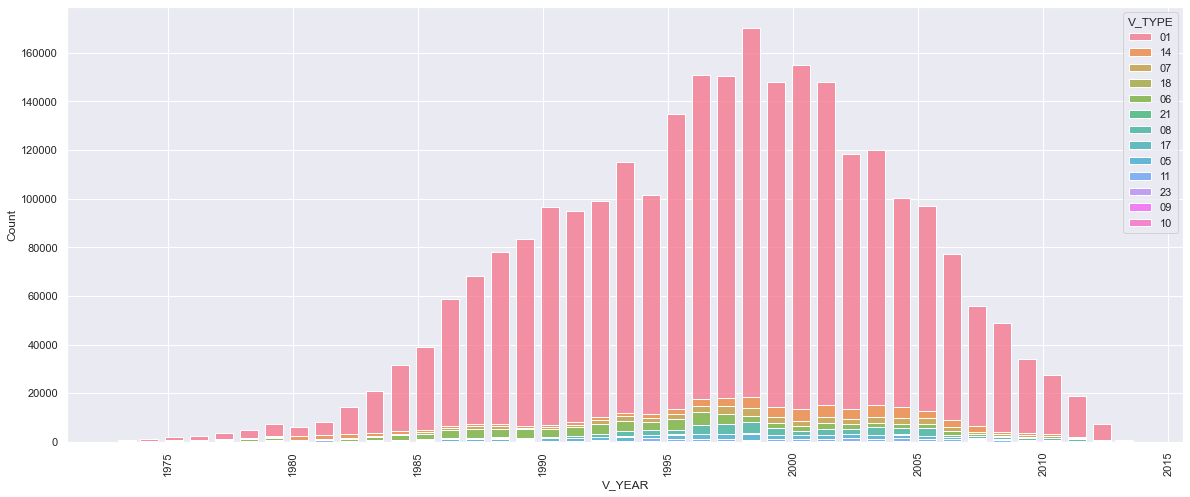

In [40]:
sns.set(rc={"figure.figsize":(20, 8)})
sns.histplot(
    df.loc[df["P_PSN"] == "11"][df["V_YEAR"] >= 1975].sort_values(by = ["V_YEAR"]).,
    x='V_YEAR',
    hue='V_TYPE',
    multiple='stack',
    shrink=5
)
plt.xticks(rotation=90)
plt.show()


Los modelos del año 1998 son los más propensos a tener accidentes. Podemos ver un claro incremento hasta este año. Esto puede verse afectado por el hecho de que la gente usa cada vez menos los modelos de coches antiguos (los cuales se destinan principalmente a exibiciones) y por ello hay menos accidentes. Además, 
A partir de 1998, gracias a las innovaciones en los modelos automovilísticos que incrementan la seguridad, la probabilidad de sufrir un accidente disminuye.
Los menos propensos a sufrir un accidente son los del tipo 21 (como hemos mencionado anteriormente) entre los años 2014-2015.

In [56]:
#Edad y género conductor
df['P_AGE']=df['P_AGE'].astype(int)

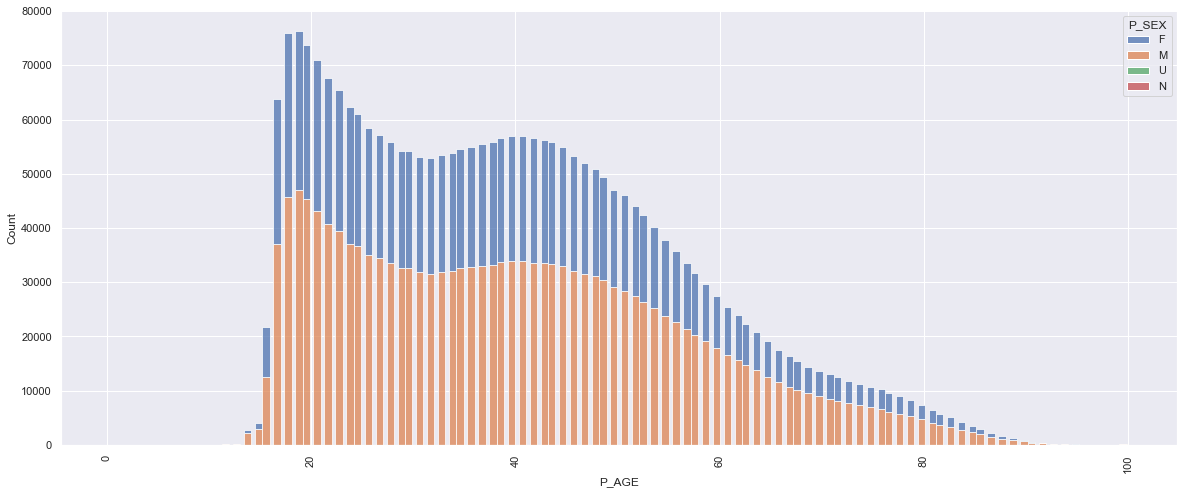

In [59]:
sns.set(rc={"figure.figsize":(20, 8)})
sns.histplot(
    df.loc[df["P_PSN"] == '11'].sort_values(by = ["P_AGE"]),
    x='P_AGE',
    hue='P_SEX',
    multiple='stack',
    shrink=2
)
plt.xticks(rotation=90)
plt.show()

La mayor parte de los accidentes son en hombres, tambien hay un mayor numero en personas de temprana edad. Esto puede ser debido a la experiencia al volante. Cuando la edad avanza, gracias a la experiencia y a un aumento de la concienciación de los peligros al volante (puede ser como consecuencia de formar una familia), el número de accidentes disminuye.
Las edades muy elevadas tienen una probabilidad muy baja, lo que puede ser debido a que poca gente a esas edades conduce.


Por tanto, los dueños de modelos de coches de tipo ligero y construidos entre 1996 y 2004 tendrán que pagar una prima mayor en el seguro. Lo mismo ocurre con los conductores más jóvenes.

## 3. Variables que causan fallecimientos

In [ ]:
df_1=df.sample(n=500000)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_1)
onehotlabels = enc.transform(df_1).toarray()

import pandas as pd
from sklearn import tree


X = df_1.drop(['P_ISEV', "C_SEV"], axis=1)
y = df_1['P_ISEV']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1000)

dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

text_representation = tree.export_text(dt)
print(text_representation)

## 4. Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecido o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.


Para generar este modelo, tendremos que tener en cuenta los datos obtenidos en el ejercicio anterior. Hemos llevado a cabo la regresión logistica que nos permite interpretar los resultados, evaluando cuales son las variables más importantes mediante los coeficientes de las variables explicativas. de esta forma conseguiremos conocer la probabilidad de que la persona fallezca o si va a necesitar tratamiento en funcion de los hechos sucedidos.

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

In [61]:
modelo =df[['P_ISEV','P_USER','P_SAFE', 'P_PSN']]
modelo

,P_ISEV,P_USER,P_SAFE,P_PSN
44,2,1,02,11
45,2,1,02,11
46,1,1,02,11
48,2,1,02,11
52,2,1,02,11
...,...,...,...,...
5860376,1,1,02,11
5860377,2,2,02,13
5860378,2,1,02,11
5860379,1,2,02,13


In [63]:
modelo1=modelo.dropna()
modelo1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
modelo1 = modelo1.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

In [64]:
modelo1.value_counts().sort_index()
#con esto sabemos el numero de variables que existen

P_ISEV  P_USER  P_SAFE  P_PSN
0       0       0       1          9560
                1       1        998786
                2       1            99
                3       1             1
                4       1           835
                                  ...  
3       2       6       10            1
        3       6       10           91
        4       6       0            55
                        1          1325
                        10           13
Length: 390, dtype: int64

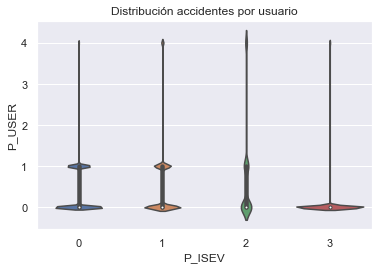

In [65]:
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'P_ISEV',
        y     = 'P_USER',
        data  = modelo1,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución accidentes por usuario');

Al realizar la grafica, observamos la relacion de los usuarios con los tipos de accidentes. por ejemplo, el P_ISEV se refiere a la severidad de las colisiones, como hemos explicado antes, el numero tres son los fallecimientos y en este caso la mayoria se produce en motociclistas (numero 5).

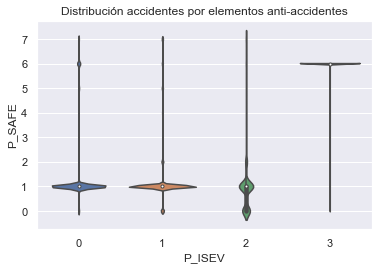

In [66]:
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'P_ISEV',
        y     = 'P_SAFE',
        data  = modelo1,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución accidentes por elementos anti-accidentes');

En este caso, lo hemos relacionado con los elementos anti accidentes que se deberian usar como casco, cinturon...

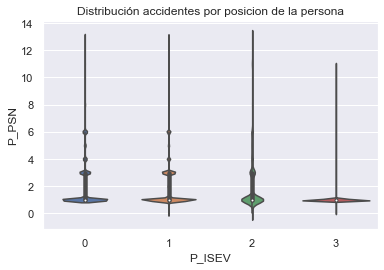

In [67]:
fig, ax = plt.subplots(figsize=(6, 3.84))

sns.violinplot(
        x     = 'P_ISEV',
        y     = 'P_PSN',
        data  = modelo1,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución accidentes por posicion de la persona');

Una vez realizados los graficos, observamos que en todos las variables existe relacion por lo que procedemos a ajustar el modelo. En primer lugar con las varibales severidad del accidente (variable respuesta) y usuarios (predictor). Utilizamos el Scikit-learn y dividimos los datos en train y test para evaluar la capacidad del modelo de predecir.

In [68]:
X = modelo1[['P_USER']]
y = modelo1['P_ISEV']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo
# Para no incluir ningún tipo de regularización en el modelo se indica
# penalty='none'
modelo_def = LogisticRegression(penalty='none')
modelo_def.fit(X = X_train.reshape(-1, 1), y = y_train)
print("Intercept:", modelo_def.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo_def.coef_.flatten(), )))
print("Accuracy de entrenamiento:", modelo_def.score(X, y))


Intercept: [ 1.56737127  1.7225504  -2.84028292 -0.44963875]
Coeficiente: [('P_USER', 0.40312620572329033)]
Accuracy de entrenamiento: 0.5361055242012787


La 'accuracy' del modelo es del 52% un poco baja. aun asi, podemos probar a predecir nuevos modelos

In [69]:
predicciones = modelo_def.predict_proba(X = X_test)
predicciones = pd.DataFrame(predicciones, columns = modelo_def.classes_)
predicciones.head(3)

,0,1,2,3
0,0.432320,0.504892,0.005267,0.057521
1,0.432320,0.504892,0.005267,0.057521
2,0.397045,0.590057,0.007692,0.005206


Con esto se obtiene, para cada observación, la probabilidad predicha de pertenecer a cada una de las dos clases.

Hacemos lo mismo con las otras variables para ver si funciona el modelo

In [72]:
X = modelo1[['P_SAFE']]
y = modelo1['P_ISEV']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


modelo_def2 = LogisticRegression(penalty='none')
modelo_def2.fit(X = X_train.reshape(-1, 1), y = y_train)

LogisticRegression(penalty='none')

In [73]:
print("Intercept:", modelo_def2.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo_def2.coef_.flatten(), )))
print("Accuracy de entrenamiento:", modelo_def2.score(X, y))

Intercept: [ 2.68100432  3.04247354 -1.2087497  -4.51472816]
Coeficiente: [('P_SAFE', -0.22839734983025184)]
Accuracy de entrenamiento: 0.559624012160629


In [74]:
predicciones = modelo_def2.predict_proba(X = X_test)
predicciones = pd.DataFrame(predicciones, columns = modelo_def2.classes_)
predicciones.head(3)

,0,1,2,3
0,0.428582,0.563501,0.006788,0.001129
1,0.306215,0.259581,0.001351,0.432853
2,0.428582,0.563501,0.006788,0.001129


In [75]:
X = modelo1[['P_PSN']]
y = modelo1['P_ISEV']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


modelo_def3 = LogisticRegression(penalty='none')
modelo_def3.fit(X = X_train.reshape(-1, 1), y = y_train)

LogisticRegression(penalty='none')

In [76]:
print("Intercept:", modelo_def3.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo_def3.coef_.flatten(), )))
print("Accuracy de entrenamiento:", modelo_def3.score(X, y))

Intercept: [ 0.92824017  1.25387079 -3.19110877  1.00899781]
Coeficiente: [('P_PSN', 0.52374719487944)]
Accuracy de entrenamiento: 0.5343562660833069


Como podemos observar, los tres modelo tienen un accuracy bajo, en torno al 53%